In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from nltk.corpus import stopwords
import string
import re
import torch.nn.functional as F
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import  os
from sklearn.preprocessing import LabelEncoder


In [2]:
is_cuda = torch.cuda.is_available()
if is_cuda == True:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Our Device =====>>>>>>", device)
df = pd.read_csv( '/kaggle/input/IMDB Dataset.csv')
df.head()

Our Device =====>>>>>> cuda


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


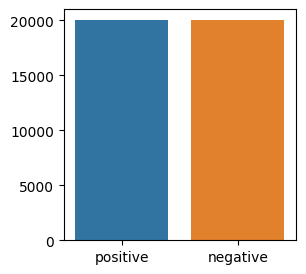

In [3]:
X = df['review'].values # Converts it into numpy array
y = df['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify = y) #stratify = y ===>positive and negative ratio of train and test data will be equal

totalcount = pd.Series(y_train).value_counts()
plt.figure(figsize=(3, 3))
sns.barplot(x = np.array(['positive', 'negative']), y= totalcount.values)
plt.show()

In [4]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []
  
    stop_words = set(stopwords.words('english'))
    for sentence in x_train:
        for word in sentence.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus_counter = Counter(word_list)
    corpus = sorted(corpus_counter, key=corpus_counter.get, reverse = True)[:1000]
    one_hot_vec_dic = {}
    for i, corp in enumerate(corpus):
        one_hot_vec_dic[corp] = i + 1
    final_x_train = []
    final_x_val = []
    
    for sentence in x_train:
        sentence_tokens = [] 
        for word in sentence.lower().split(): 
            ppword = preprocess_string(word)
            if ppword in one_hot_vec_dic.keys():
                sentence_tokens.append(one_hot_vec_dic[ppword])
        final_x_train.append(sentence_tokens)
  

    for sentence in x_val:
        sentence_tokens = [] 
        for word in sentence.lower().split(): 
            ppword = preprocess_string(word)
            if ppword in one_hot_vec_dic.keys():
                sentence_tokens.append(one_hot_vec_dic[ppword])
        final_x_val.append(sentence_tokens)  
       
    le = LabelEncoder()
    encode_train = le.fit_transform(y_train)
    encode_val = le.fit_transform(y_val)
    return final_x_train,final_x_val, encode_train, encode_val, one_hot_vec_dic
    

            
        
st = ['World is beautiful. beautiful beautiful beautiful USA is the best beautiful . I will go to USA only.']

labels = ['positive', 'negative', 'positive', 'negative', 'positive']

tockenize(st,labels,st,labels)       

X_train, X_test, Y_train, Y_test, vocab = tockenize(x_train, y_train, x_test, y_test)

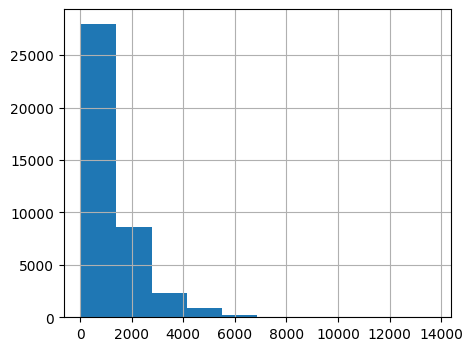

In [5]:
length_x_train = []
for i in x_train:
    length_x_train.append(len(i))

plt.figure(figsize=(5, 4)) 
pd.Series(length_x_train).hist()
plt.show()

In [6]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [7]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(X_train,500)
x_test_pad = padding_(X_test,500)

In [8]:
# create Tensor datasets
print(x_train_pad.dtype)
print(Y_train.dtype)

train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(Y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(Y_test))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,  drop_last = True)

int64
int64


In [9]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, output_dim, hidden_dim, embedding_dim,drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim )
        self.rnn = nn.RNN(input_size = embedding_dim, hidden_size = self.hidden_dim, num_layers = no_layers, batch_first = True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
        self.sig = nn.Sigmoid()
       



# batch_size = 5
# seq_length = 10
# hidden_dim = 20
# num_layers = 1

# rnn_out, hidden = self.rnn(embedding_layer, hidden)
# Then:

# rnn_out.shape → (5, 10, 20) (all hidden states for all words)
# hidden.shape → (1, 5, 20) (final hidden state for each sequence)
# rnn_out[:, -1, :] → (5, 20) (last word's output)
# hidden.squeeze(0) → (5, 20) (last hidden state)

    def forward(self,x,hidden):
        batch_size = x.size(0)
        print('=====>>>', batch_size)
        embeding_layer = self.embedding(x)
        rnn_out, hidden = self.rnn(embeding_layer, hidden)
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim) 
        out = self.dropout(rnn_out)
        out = self.fc(out)
        sig_out = self.sig(out)  
        batch_size = x.size(0)
        sig_out = sig_out.view(batch_size, -1) 
        sig_out = sig_out[:, -1] 
        return sig_out, hidden


    def init_hidden(self, batch_size):
        #intializing first hidden state
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        return (h0,c0)
        
        

In [11]:
no_layers = 2
vocab_size = len(vocab) + 1 
embedding_dim = 64
output_dim = 1
hidden_dim = 256
model = SentimentRNN(no_layers,vocab_size,output_dim, hidden_dim, embedding_dim,drop_prob=0.5)
model.to(device)
print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (rnn): RNN(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [12]:
lr = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [13]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    print('test')
    train_acc = 0.0
    model.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        h, c = model.init_hidden(batch_size)
        output,h = model(inputs,h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.detach().item())
        accuracy = acc(output.detach(),labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            # val_h, val_c = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            val_h, val_c = model.init_hidden(batch_size)
        
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy


    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
        

test


  0%|          | 0/312 [00:00<?, ?it/s]

=====>>> 128


  1%|          | 3/312 [00:01<01:32,  3.34it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  3%|▎         | 8/312 [00:01<00:31,  9.63it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  4%|▍         | 14/312 [00:01<00:18, 15.88it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  5%|▌         | 17/312 [00:01<00:16, 18.17it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  7%|▋         | 23/312 [00:01<00:13, 21.27it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  9%|▉         | 29/312 [00:02<00:12, 22.92it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 10%|█         | 32/312 [00:02<00:12, 23.30it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 12%|█▏        | 38/312 [00:02<00:11, 24.04it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 14%|█▍        | 44/312 [00:02<00:11, 24.36it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 15%|█▌        | 47/312 [00:02<00:10, 24.35it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 17%|█▋        | 53/312 [00:03<00:10, 24.50it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 19%|█▉        | 59/312 [00:03<00:10, 24.68it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 20%|█▉        | 62/312 [00:03<00:10, 24.72it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 22%|██▏       | 68/312 [00:03<00:09, 24.91it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 24%|██▎       | 74/312 [00:03<00:09, 24.83it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 26%|██▌       | 80/312 [00:04<00:09, 24.72it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 28%|██▊       | 86/312 [00:04<00:09, 24.78it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 29%|██▉       | 92/312 [00:04<00:08, 24.81it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 30%|███       | 95/312 [00:04<00:08, 24.87it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 32%|███▏      | 101/312 [00:05<00:08, 24.81it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 34%|███▍      | 107/312 [00:05<00:08, 24.77it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 36%|███▌      | 113/312 [00:05<00:08, 24.80it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 38%|███▊      | 119/312 [00:05<00:07, 24.79it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 39%|███▉      | 122/312 [00:05<00:07, 24.78it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128

 41%|████      | 128/312 [00:06<00:07, 24.76it/s]


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 43%|████▎     | 134/312 [00:06<00:07, 24.76it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 44%|████▍     | 137/312 [00:06<00:07, 24.68it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 46%|████▌     | 143/312 [00:06<00:06, 24.58it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 47%|████▋     | 146/312 [00:06<00:06, 24.46it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 49%|████▊     | 152/312 [00:07<00:06, 24.27it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 51%|█████     | 158/312 [00:07<00:06, 24.40it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 52%|█████▏    | 161/312 [00:07<00:06, 24.42it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 54%|█████▎    | 167/312 [00:07<00:05, 24.60it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 55%|█████▌    | 173/312 [00:08<00:05, 24.75it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 57%|█████▋    | 179/312 [00:08<00:05, 24.76it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 59%|█████▉    | 185/312 [00:08<00:05, 24.69it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 61%|██████    | 191/312 [00:08<00:04, 24.81it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 63%|██████▎   | 197/312 [00:08<00:04, 24.72it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 64%|██████▍   | 200/312 [00:09<00:04, 24.72it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 66%|██████▌   | 206/312 [00:09<00:04, 24.81it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 68%|██████▊   | 212/312 [00:09<00:04, 24.86it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 70%|██████▉   | 218/312 [00:09<00:03, 24.83it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 71%|███████   | 221/312 [00:09<00:03, 24.76it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 73%|███████▎  | 227/312 [00:10<00:03, 24.83it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 75%|███████▍  | 233/312 [00:10<00:03, 24.79it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 77%|███████▋  | 239/312 [00:10<00:02, 24.70it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 79%|███████▊  | 245/312 [00:10<00:02, 24.70it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 79%|███████▉  | 248/312 [00:11<00:02, 24.69it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128

 81%|████████▏ | 254/312 [00:11<00:02, 24.75it/s]


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 83%|████████▎ | 260/312 [00:11<00:02, 24.76it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 85%|████████▌ | 266/312 [00:11<00:01, 24.79it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 86%|████████▌ | 269/312 [00:11<00:01, 24.76it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 88%|████████▊ | 275/312 [00:12<00:01, 24.75it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 90%|█████████ | 281/312 [00:12<00:01, 24.73it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 91%|█████████ | 284/312 [00:12<00:01, 24.70it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 93%|█████████▎| 290/312 [00:12<00:00, 24.65it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 94%|█████████▍| 293/312 [00:12<00:00, 24.58it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 96%|█████████▌| 299/312 [00:13<00:00, 24.16it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 98%|█████████▊| 305/312 [00:13<00:00, 24.20it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


100%|█████████▉| 311/312 [00:13<00:00, 24.43it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


100%|██████████| 312/312 [00:13<00:00, 22.87it/s]


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128

  1%|          | 3/312 [00:00<00:12, 24.58it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  2%|▏         | 6/312 [00:00<00:12, 24.48it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  3%|▎         | 9/312 [00:00<00:12, 24.45it/s]

=====>>> 128


  4%|▍         | 12/312 [00:00<00:12, 24.16it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  6%|▌         | 18/312 [00:00<00:12, 24.05it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  7%|▋         | 21/312 [00:00<00:12, 24.18it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  8%|▊         | 24/312 [00:00<00:11, 24.30it/s]

=====>>> 128


  9%|▊         | 27/312 [00:01<00:11, 24.55it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 11%|█         | 33/312 [00:01<00:11, 24.60it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 12%|█▎        | 39/312 [00:01<00:11, 24.69it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 14%|█▍        | 45/312 [00:01<00:10, 24.78it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 15%|█▌        | 48/312 [00:01<00:10, 24.78it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 17%|█▋        | 54/312 [00:02<00:10, 24.74it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 19%|█▉        | 60/312 [00:02<00:10, 24.73it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 21%|██        | 66/312 [00:02<00:09, 24.85it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 23%|██▎       | 72/312 [00:02<00:09, 24.78it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 25%|██▌       | 78/312 [00:03<00:09, 24.73it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 26%|██▌       | 81/312 [00:03<00:09, 24.78it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 28%|██▊       | 87/312 [00:03<00:09, 24.75it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 30%|██▉       | 93/312 [00:03<00:08, 24.81it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 32%|███▏      | 99/312 [00:04<00:08, 24.79it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 33%|███▎      | 102/312 [00:04<00:08, 24.81it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 35%|███▍      | 108/312 [00:04<00:08, 24.77it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 37%|███▋      | 114/312 [00:04<00:08, 24.74it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 38%|███▊      | 120/312 [00:04<00:07, 24.78it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 39%|███▉      | 123/312 [00:04<00:07, 24.74it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 41%|████▏     | 129/312 [00:05<00:07, 24.74it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 43%|████▎     | 135/312 [00:05<00:07, 24.77it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 44%|████▍     | 138/312 [00:05<00:07, 24.76it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 46%|████▌     | 144/312 [00:05<00:06, 24.77it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 48%|████▊     | 150/312 [00:06<00:06, 24.84it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 50%|█████     | 156/312 [00:06<00:06, 24.84it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 52%|█████▏    | 162/312 [00:06<00:06, 24.85it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 53%|█████▎    | 165/312 [00:06<00:05, 24.80it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 55%|█████▍    | 171/312 [00:06<00:05, 24.78it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 57%|█████▋    | 177/312 [00:07<00:05, 24.74it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 58%|█████▊    | 180/312 [00:07<00:05, 24.69it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 60%|█████▉    | 186/312 [00:07<00:05, 24.64it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 61%|██████    | 189/312 [00:07<00:05, 24.42it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 62%|██████▎   | 195/312 [00:07<00:04, 24.11it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 64%|██████▍   | 201/312 [00:08<00:04, 24.35it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 66%|██████▋   | 207/312 [00:08<00:04, 24.56it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 67%|██████▋   | 210/312 [00:08<00:04, 24.59it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 69%|██████▉   | 216/312 [00:08<00:03, 24.55it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 70%|███████   | 219/312 [00:08<00:03, 24.31it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 72%|███████▏  | 225/312 [00:09<00:03, 24.16it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 74%|███████▍  | 231/312 [00:09<00:03, 24.33it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 76%|███████▌  | 237/312 [00:09<00:03, 24.60it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 77%|███████▋  | 240/312 [00:09<00:02, 24.54it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 79%|███████▉  | 246/312 [00:09<00:02, 24.62it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 81%|████████  | 252/312 [00:10<00:02, 24.64it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 82%|████████▏ | 255/312 [00:10<00:02, 24.62it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 84%|████████▎ | 261/312 [00:10<00:02, 24.52it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 85%|████████▍ | 264/312 [00:10<00:01, 24.28it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 87%|████████▋ | 270/312 [00:10<00:01, 24.19it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 88%|████████▊ | 276/312 [00:11<00:01, 24.10it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 89%|████████▉ | 279/312 [00:11<00:01, 24.18it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 91%|█████████▏| 285/312 [00:11<00:01, 23.81it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 93%|█████████▎| 291/312 [00:11<00:00, 24.11it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 94%|█████████▍| 294/312 [00:11<00:00, 24.24it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 96%|█████████▌| 300/312 [00:12<00:00, 24.35it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 98%|█████████▊| 306/312 [00:12<00:00, 24.02it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 99%|█████████▉| 309/312 [00:12<00:00, 24.05it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


100%|██████████| 312/312 [00:12<00:00, 24.52it/s]


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128

  0%|          | 0/312 [00:00<?, ?it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  1%|          | 3/312 [00:00<00:12, 24.11it/s]

=====>>> 128
=====>>> 128


  2%|▏         | 6/312 [00:00<00:12, 24.42it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  3%|▎         | 9/312 [00:00<00:12, 24.40it/s]

=====>>> 128
=====>>> 128


  4%|▍         | 12/312 [00:00<00:12, 24.40it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  5%|▍         | 15/312 [00:00<00:12, 24.25it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  6%|▌         | 18/312 [00:00<00:12, 23.90it/s]

=====>>> 128
=====>>> 128


  7%|▋         | 21/312 [00:00<00:12, 23.93it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  8%|▊         | 24/312 [00:00<00:11, 24.05it/s]

=====>>> 128
=====>>> 128


  9%|▊         | 27/312 [00:01<00:11, 24.14it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 10%|▉         | 30/312 [00:01<00:11, 24.18it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 11%|█         | 33/312 [00:01<00:11, 24.12it/s]

=====>>> 128
=====>>> 128


 12%|█▏        | 36/312 [00:01<00:11, 23.84it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 12%|█▎        | 39/312 [00:01<00:11, 23.90it/s]

=====>>> 128
=====>>> 128


 13%|█▎        | 42/312 [00:01<00:11, 23.98it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 14%|█▍        | 45/312 [00:01<00:11, 24.11it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 15%|█▌        | 48/312 [00:01<00:10, 24.14it/s]

=====>>> 128
=====>>> 128


 16%|█▋        | 51/312 [00:02<00:10, 23.87it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 17%|█▋        | 54/312 [00:02<00:10, 23.94it/s]

=====>>> 128
=====>>> 128


 18%|█▊        | 57/312 [00:02<00:10, 23.95it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 19%|█▉        | 60/312 [00:02<00:10, 24.13it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 20%|██        | 63/312 [00:02<00:10, 24.21it/s]

=====>>> 128
=====>>> 128


 21%|██        | 66/312 [00:02<00:10, 24.21it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 22%|██▏       | 69/312 [00:02<00:10, 23.88it/s]

=====>>> 128
=====>>> 128


 23%|██▎       | 72/312 [00:02<00:10, 23.89it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 24%|██▍       | 75/312 [00:03<00:09, 23.97it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 25%|██▌       | 78/312 [00:03<00:09, 24.08it/s]

=====>>> 128
=====>>> 128


 26%|██▌       | 81/312 [00:03<00:09, 23.89it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 27%|██▋       | 84/312 [00:03<00:09, 23.79it/s]

=====>>> 128
=====>>> 128


 28%|██▊       | 87/312 [00:03<00:09, 23.87it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 29%|██▉       | 90/312 [00:03<00:09, 24.02it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 30%|██▉       | 93/312 [00:03<00:09, 24.12it/s]

=====>>> 128
=====>>> 128


 31%|███       | 96/312 [00:03<00:08, 24.10it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 32%|███▏      | 99/312 [00:04<00:08, 23.84it/s]

=====>>> 128
=====>>> 128


 33%|███▎      | 102/312 [00:04<00:08, 23.87it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 34%|███▎      | 105/312 [00:04<00:08, 23.91it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 35%|███▍      | 108/312 [00:04<00:08, 23.85it/s]

=====>>> 128
=====>>> 128


 36%|███▌      | 111/312 [00:04<00:08, 23.67it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 37%|███▋      | 114/312 [00:04<00:08, 23.72it/s]

=====>>> 128
=====>>> 128


 38%|███▊      | 117/312 [00:04<00:08, 23.87it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 38%|███▊      | 120/312 [00:05<00:08, 23.89it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 39%|███▉      | 123/312 [00:05<00:07, 23.63it/s]

=====>>> 128
=====>>> 128


 40%|████      | 126/312 [00:05<00:07, 23.74it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 41%|████▏     | 129/312 [00:05<00:07, 23.96it/s]

=====>>> 128
=====>>> 128


 42%|████▏     | 132/312 [00:05<00:07, 24.08it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 43%|████▎     | 135/312 [00:05<00:07, 24.08it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 44%|████▍     | 138/312 [00:05<00:07, 23.70it/s]

=====>>> 128
=====>>> 128


 45%|████▌     | 141/312 [00:05<00:07, 23.78it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 46%|████▌     | 144/312 [00:06<00:07, 23.82it/s]

=====>>> 128
=====>>> 128


 47%|████▋     | 147/312 [00:06<00:06, 23.68it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 48%|████▊     | 150/312 [00:06<00:06, 23.59it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 49%|████▉     | 153/312 [00:06<00:06, 23.71it/s]

=====>>> 128
=====>>> 128


 50%|█████     | 156/312 [00:06<00:06, 23.81it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 51%|█████     | 159/312 [00:06<00:06, 23.60it/s]

=====>>> 128
=====>>> 128


 52%|█████▏    | 162/312 [00:06<00:06, 23.61it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 53%|█████▎    | 165/312 [00:06<00:06, 23.69it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 54%|█████▍    | 168/312 [00:07<00:06, 23.57it/s]

=====>>> 128
=====>>> 128


 55%|█████▍    | 171/312 [00:07<00:05, 23.53it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 56%|█████▌    | 174/312 [00:07<00:05, 23.67it/s]

=====>>> 128
=====>>> 128


 57%|█████▋    | 177/312 [00:07<00:05, 23.71it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 58%|█████▊    | 180/312 [00:07<00:05, 23.46it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 59%|█████▊    | 183/312 [00:07<00:05, 23.59it/s]

=====>>> 128
=====>>> 128


 60%|█████▉    | 186/312 [00:07<00:05, 23.71it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 61%|██████    | 189/312 [00:07<00:05, 23.48it/s]

=====>>> 128
=====>>> 128


 62%|██████▏   | 192/312 [00:08<00:05, 23.61it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 62%|██████▎   | 195/312 [00:08<00:04, 23.74it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 63%|██████▎   | 198/312 [00:08<00:04, 23.77it/s]

=====>>> 128
=====>>> 128


 64%|██████▍   | 201/312 [00:08<00:04, 23.55it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 65%|██████▌   | 204/312 [00:08<00:04, 23.58it/s]

=====>>> 128
=====>>> 128


 66%|██████▋   | 207/312 [00:08<00:04, 23.72it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 67%|██████▋   | 210/312 [00:08<00:04, 23.75it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 68%|██████▊   | 213/312 [00:08<00:04, 23.55it/s]

=====>>> 128
=====>>> 128


 69%|██████▉   | 216/312 [00:09<00:04, 23.65it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 70%|███████   | 219/312 [00:09<00:03, 23.72it/s]

=====>>> 128
=====>>> 128


 71%|███████   | 222/312 [00:09<00:03, 23.49it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 72%|███████▏  | 225/312 [00:09<00:03, 23.50it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 73%|███████▎  | 228/312 [00:09<00:03, 23.62it/s]

=====>>> 128
=====>>> 128


 74%|███████▍  | 231/312 [00:09<00:03, 23.48it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 75%|███████▌  | 234/312 [00:09<00:03, 23.48it/s]

=====>>> 128
=====>>> 128


 76%|███████▌  | 237/312 [00:09<00:03, 23.65it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 77%|███████▋  | 240/312 [00:10<00:03, 23.71it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 78%|███████▊  | 243/312 [00:10<00:02, 23.54it/s]

=====>>> 128
=====>>> 128


 79%|███████▉  | 246/312 [00:10<00:02, 23.71it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 80%|███████▉  | 249/312 [00:10<00:02, 23.85it/s]

=====>>> 128
=====>>> 128


 81%|████████  | 252/312 [00:10<00:02, 23.88it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 82%|████████▏ | 255/312 [00:10<00:02, 23.63it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 83%|████████▎ | 258/312 [00:10<00:02, 23.63it/s]

=====>>> 128
=====>>> 128


 84%|████████▎ | 261/312 [00:10<00:02, 23.77it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 85%|████████▍ | 264/312 [00:11<00:02, 23.74it/s]

=====>>> 128
=====>>> 128


 86%|████████▌ | 267/312 [00:11<00:01, 23.55it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 87%|████████▋ | 270/312 [00:11<00:01, 23.60it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 88%|████████▊ | 273/312 [00:11<00:01, 23.72it/s]

=====>>> 128
=====>>> 128


 88%|████████▊ | 276/312 [00:11<00:01, 23.45it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 89%|████████▉ | 279/312 [00:11<00:01, 23.37it/s]

=====>>> 128
=====>>> 128


 90%|█████████ | 282/312 [00:11<00:01, 23.50it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 91%|█████████▏| 285/312 [00:11<00:01, 23.32it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 92%|█████████▏| 288/312 [00:12<00:01, 23.44it/s]

=====>>> 128
=====>>> 128


 93%|█████████▎| 291/312 [00:12<00:00, 23.64it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 94%|█████████▍| 294/312 [00:12<00:00, 23.32it/s]

=====>>> 128
=====>>> 128


 95%|█████████▌| 297/312 [00:12<00:00, 23.38it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 96%|█████████▌| 300/312 [00:12<00:00, 23.39it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 97%|█████████▋| 303/312 [00:12<00:00, 23.23it/s]

=====>>> 128
=====>>> 128


 98%|█████████▊| 306/312 [00:12<00:00, 23.41it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 99%|█████████▉| 309/312 [00:13<00:00, 23.39it/s]

=====>>> 128
=====>>> 128


100%|██████████| 312/312 [00:13<00:00, 23.74it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
Epoch 3
trai

  0%|          | 0/312 [00:00<?, ?it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  1%|          | 3/312 [00:00<00:13, 23.36it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  2%|▏         | 6/312 [00:00<00:12, 23.54it/s]

=====>>> 128
=====>>> 128


  3%|▎         | 9/312 [00:00<00:12, 23.38it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  4%|▍         | 12/312 [00:00<00:12, 23.24it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  5%|▍         | 15/312 [00:00<00:12, 23.40it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  6%|▌         | 18/312 [00:00<00:12, 23.16it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  7%|▋         | 21/312 [00:00<00:12, 23.34it/s]

=====>>> 128
=====>>> 128


  8%|▊         | 24/312 [00:01<00:12, 23.37it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  9%|▊         | 27/312 [00:01<00:12, 23.15it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 10%|▉         | 30/312 [00:01<00:12, 23.34it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 11%|█         | 33/312 [00:01<00:12, 23.11it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 12%|█▏        | 36/312 [00:01<00:11, 23.23it/s]

=====>>> 128
=====>>> 128


 12%|█▎        | 39/312 [00:01<00:11, 23.19it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 13%|█▎        | 42/312 [00:01<00:11, 23.23it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 14%|█▍        | 45/312 [00:01<00:11, 23.32it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 15%|█▌        | 48/312 [00:02<00:11, 23.21it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 16%|█▋        | 51/312 [00:02<00:11, 23.31it/s]

=====>>> 128
=====>>> 128


 17%|█▋        | 54/312 [00:02<00:11, 23.36it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 18%|█▊        | 57/312 [00:02<00:10, 23.22it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 19%|█▉        | 60/312 [00:02<00:10, 23.35it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 20%|██        | 63/312 [00:02<00:10, 23.19it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 21%|██        | 66/312 [00:02<00:10, 23.26it/s]

=====>>> 128
=====>>> 128


 22%|██▏       | 69/312 [00:02<00:10, 23.43it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 23%|██▎       | 72/312 [00:03<00:10, 23.25it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 24%|██▍       | 75/312 [00:03<00:10, 23.39it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 25%|██▌       | 78/312 [00:03<00:09, 23.51it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 26%|██▌       | 81/312 [00:03<00:09, 23.34it/s]

=====>>> 128
=====>>> 128


 27%|██▋       | 84/312 [00:03<00:09, 23.40it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 28%|██▊       | 87/312 [00:03<00:09, 23.26it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 29%|██▉       | 90/312 [00:03<00:09, 23.27it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 30%|██▉       | 93/312 [00:03<00:09, 23.39it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 31%|███       | 96/312 [00:04<00:09, 23.18it/s]

=====>>> 128
=====>>> 128


 32%|███▏      | 99/312 [00:04<00:09, 23.37it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 33%|███▎      | 102/312 [00:04<00:08, 23.52it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 34%|███▎      | 105/312 [00:04<00:08, 23.43it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 35%|███▍      | 108/312 [00:04<00:08, 23.44it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 36%|███▌      | 111/312 [00:04<00:08, 23.58it/s]

=====>>> 128
=====>>> 128


 37%|███▋      | 114/312 [00:04<00:08, 23.41it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 38%|███▊      | 117/312 [00:05<00:08, 23.42it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 38%|███▊      | 120/312 [00:05<00:08, 23.48it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 39%|███▉      | 123/312 [00:05<00:08, 23.35it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 40%|████      | 126/312 [00:05<00:07, 23.48it/s]

=====>>> 128
=====>>> 128


 41%|████▏     | 129/312 [00:05<00:07, 23.59it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 42%|████▏     | 132/312 [00:05<00:07, 23.41it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 43%|████▎     | 135/312 [00:05<00:07, 23.45it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 44%|████▍     | 138/312 [00:05<00:07, 23.50it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 45%|████▌     | 141/312 [00:06<00:07, 23.29it/s]

=====>>> 128
=====>>> 128


 46%|████▌     | 144/312 [00:06<00:07, 23.37it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 47%|████▋     | 147/312 [00:06<00:07, 23.48it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 48%|████▊     | 150/312 [00:06<00:06, 23.32it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 49%|████▉     | 153/312 [00:06<00:06, 23.34it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 50%|█████     | 156/312 [00:06<00:06, 23.21it/s]

=====>>> 128
=====>>> 128


 51%|█████     | 159/312 [00:06<00:06, 23.27it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 52%|█████▏    | 162/312 [00:06<00:06, 23.40it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 53%|█████▎    | 165/312 [00:07<00:06, 23.18it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 54%|█████▍    | 168/312 [00:07<00:06, 23.19it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 55%|█████▍    | 171/312 [00:07<00:06, 23.20it/s]

=====>>> 128
=====>>> 128


 56%|█████▌    | 174/312 [00:07<00:05, 23.25it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 57%|█████▋    | 177/312 [00:07<00:05, 23.40it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 58%|█████▊    | 180/312 [00:07<00:05, 23.26it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 59%|█████▊    | 183/312 [00:07<00:05, 23.41it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 60%|█████▉    | 186/312 [00:07<00:05, 23.51it/s]

=====>>> 128
=====>>> 128


 61%|██████    | 189/312 [00:08<00:05, 23.35it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 62%|██████▏   | 192/312 [00:08<00:05, 23.37it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 62%|██████▎   | 195/312 [00:08<00:04, 23.45it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 63%|██████▎   | 198/312 [00:08<00:04, 23.26it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 64%|██████▍   | 201/312 [00:08<00:04, 23.37it/s]

=====>>> 128
=====>>> 128


 65%|██████▌   | 204/312 [00:08<00:04, 23.49it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 66%|██████▋   | 207/312 [00:08<00:04, 23.32it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 67%|██████▋   | 210/312 [00:08<00:04, 23.40it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 68%|██████▊   | 213/312 [00:09<00:04, 23.52it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 69%|██████▉   | 216/312 [00:09<00:04, 23.31it/s]

=====>>> 128
=====>>> 128


 70%|███████   | 219/312 [00:09<00:03, 23.38it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 71%|███████   | 222/312 [00:09<00:03, 23.26it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 72%|███████▏  | 225/312 [00:09<00:03, 23.27it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 73%|███████▎  | 228/312 [00:09<00:03, 23.38it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 74%|███████▍  | 231/312 [00:09<00:03, 23.21it/s]

=====>>> 128
=====>>> 128


 75%|███████▌  | 234/312 [00:10<00:03, 23.31it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 76%|███████▌  | 237/312 [00:10<00:03, 23.15it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 77%|███████▋  | 240/312 [00:10<00:03, 23.10it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 78%|███████▊  | 243/312 [00:10<00:02, 23.20it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 79%|███████▉  | 246/312 [00:10<00:02, 23.00it/s]

=====>>> 128
=====>>> 128


 80%|███████▉  | 249/312 [00:10<00:02, 23.15it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 81%|████████  | 252/312 [00:10<00:02, 23.09it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 82%|████████▏ | 255/312 [00:10<00:02, 23.26it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 83%|████████▎ | 258/312 [00:11<00:02, 23.48it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 84%|████████▎ | 261/312 [00:11<00:02, 23.28it/s]

=====>>> 128
=====>>> 128


 85%|████████▍ | 264/312 [00:11<00:02, 23.41it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 86%|████████▌ | 267/312 [00:11<00:01, 23.53it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 87%|████████▋ | 270/312 [00:11<00:01, 23.32it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 88%|████████▊ | 273/312 [00:11<00:01, 23.42it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 88%|████████▊ | 276/312 [00:11<00:01, 23.53it/s]

=====>>> 128
=====>>> 128


 89%|████████▉ | 279/312 [00:11<00:01, 23.32it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 90%|█████████ | 282/312 [00:12<00:01, 23.46it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 91%|█████████▏| 285/312 [00:12<00:01, 23.62it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 92%|█████████▏| 288/312 [00:12<00:01, 23.59it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 93%|█████████▎| 291/312 [00:12<00:00, 23.37it/s]

=====>>> 128
=====>>> 128


 94%|█████████▍| 294/312 [00:12<00:00, 23.43it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 95%|█████████▌| 297/312 [00:12<00:00, 23.30it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 96%|█████████▌| 300/312 [00:12<00:00, 23.35it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 97%|█████████▋| 303/312 [00:12<00:00, 23.40it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 98%|█████████▊| 306/312 [00:13<00:00, 23.27it/s]

=====>>> 128
=====>>> 128


 99%|█████████▉| 309/312 [00:13<00:00, 23.39it/s]

=====>>> 128
=====>>> 128
=====>>> 128


100%|██████████| 312/312 [00:13<00:00, 23.34it/s]

=====>>> 128
=====>>> 128
=====>>> 128


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
Epoch 4
trai

  0%|          | 0/312 [00:00<?, ?it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  1%|          | 3/312 [00:00<00:13, 23.30it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  2%|▏         | 6/312 [00:00<00:13, 23.49it/s]

=====>>> 128
=====>>> 128


  3%|▎         | 9/312 [00:00<00:13, 23.23it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  4%|▍         | 12/312 [00:00<00:12, 23.40it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


  5%|▍         | 15/312 [00:00<00:12, 23.43it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  6%|▌         | 18/312 [00:00<00:12, 23.25it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  7%|▋         | 21/312 [00:00<00:12, 23.35it/s]

=====>>> 128
=====>>> 128


  8%|▊         | 24/312 [00:01<00:12, 23.19it/s]

=====>>> 128
=====>>> 128
=====>>> 128


  9%|▊         | 27/312 [00:01<00:12, 23.26it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 10%|▉         | 30/312 [00:01<00:12, 23.30it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 11%|█         | 33/312 [00:01<00:12, 23.23it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 12%|█▏        | 36/312 [00:01<00:11, 23.36it/s]

=====>>> 128
=====>>> 128


 12%|█▎        | 39/312 [00:01<00:11, 23.23it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 13%|█▎        | 42/312 [00:01<00:11, 23.25it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 14%|█▍        | 45/312 [00:01<00:11, 23.36it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 15%|█▌        | 48/312 [00:02<00:11, 23.17it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 16%|█▋        | 51/312 [00:02<00:11, 23.31it/s]

=====>>> 128
=====>>> 128


 17%|█▋        | 54/312 [00:02<00:11, 23.13it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 18%|█▊        | 57/312 [00:02<00:11, 23.02it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 19%|█▉        | 60/312 [00:02<00:10, 22.97it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 20%|██        | 63/312 [00:02<00:10, 23.08it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 21%|██        | 66/312 [00:02<00:10, 23.08it/s]

=====>>> 128
=====>>> 128


 22%|██▏       | 69/312 [00:02<00:10, 23.04it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 23%|██▎       | 72/312 [00:03<00:10, 23.24it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 24%|██▍       | 75/312 [00:03<00:10, 23.09it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 25%|██▌       | 78/312 [00:03<00:10, 23.28it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 26%|██▌       | 81/312 [00:03<00:09, 23.29it/s]

=====>>> 128
=====>>> 128


 27%|██▋       | 84/312 [00:03<00:09, 23.17it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 28%|██▊       | 87/312 [00:03<00:09, 23.29it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 29%|██▉       | 90/312 [00:03<00:09, 23.12it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 30%|██▉       | 93/312 [00:04<00:09, 23.26it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 31%|███       | 96/312 [00:04<00:09, 23.38it/s]

=====>>> 128
=====>>> 128


 32%|███▏      | 99/312 [00:04<00:09, 23.18it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 33%|███▎      | 102/312 [00:04<00:08, 23.34it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 34%|███▎      | 105/312 [00:04<00:08, 23.17it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 35%|███▍      | 108/312 [00:04<00:08, 23.23it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 36%|███▌      | 111/312 [00:04<00:08, 23.26it/s]

=====>>> 128
=====>>> 128


 37%|███▋      | 114/312 [00:04<00:08, 23.12it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 38%|███▊      | 117/312 [00:05<00:08, 23.20it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 38%|███▊      | 120/312 [00:05<00:08, 23.14it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 39%|███▉      | 123/312 [00:05<00:08, 23.23it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 40%|████      | 126/312 [00:05<00:08, 23.06it/s]

=====>>> 128
=====>>> 128


 41%|████▏     | 129/312 [00:05<00:07, 23.09it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 42%|████▏     | 132/312 [00:05<00:07, 23.09it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 43%|████▎     | 135/312 [00:05<00:07, 23.09it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 44%|████▍     | 138/312 [00:05<00:07, 23.26it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 45%|████▌     | 141/312 [00:06<00:07, 23.04it/s]

=====>>> 128
=====>>> 128


 46%|████▌     | 144/312 [00:06<00:07, 23.15it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 47%|████▋     | 147/312 [00:06<00:07, 23.01it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 48%|████▊     | 150/312 [00:06<00:07, 23.12it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 49%|████▉     | 153/312 [00:06<00:06, 23.04it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 50%|█████     | 156/312 [00:06<00:06, 23.02it/s]

=====>>> 128
=====>>> 128


 51%|█████     | 159/312 [00:06<00:06, 22.96it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 52%|█████▏    | 162/312 [00:06<00:06, 22.99it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 53%|█████▎    | 165/312 [00:07<00:06, 23.04it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 54%|█████▍    | 168/312 [00:07<00:06, 22.93it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 55%|█████▍    | 171/312 [00:07<00:06, 23.04it/s]

=====>>> 128
=====>>> 128


 56%|█████▌    | 174/312 [00:07<00:06, 22.75it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 57%|█████▋    | 177/312 [00:07<00:05, 22.61it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 58%|█████▊    | 180/312 [00:07<00:05, 22.73it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 59%|█████▊    | 183/312 [00:07<00:05, 22.58it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 60%|█████▉    | 186/312 [00:08<00:05, 22.75it/s]

=====>>> 128
=====>>> 128


 61%|██████    | 189/312 [00:08<00:05, 22.61it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 62%|██████▏   | 192/312 [00:08<00:05, 22.74it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 62%|██████▎   | 195/312 [00:08<00:05, 22.57it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 63%|██████▎   | 198/312 [00:08<00:05, 22.59it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 64%|██████▍   | 201/312 [00:08<00:04, 22.69it/s]

=====>>> 128
=====>>> 128


 65%|██████▌   | 204/312 [00:08<00:04, 22.68it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 66%|██████▋   | 207/312 [00:08<00:04, 22.84it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 67%|██████▋   | 210/312 [00:09<00:04, 22.86it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 68%|██████▊   | 213/312 [00:09<00:04, 22.91it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 69%|██████▉   | 216/312 [00:09<00:04, 22.97it/s]

=====>>> 128
=====>>> 128


 70%|███████   | 219/312 [00:09<00:04, 22.84it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 71%|███████   | 222/312 [00:09<00:03, 22.98it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 72%|███████▏  | 225/312 [00:09<00:03, 22.85it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 73%|███████▎  | 228/312 [00:09<00:03, 22.86it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 74%|███████▍  | 231/312 [00:10<00:03, 22.81it/s]

=====>>> 128
=====>>> 128


 75%|███████▌  | 234/312 [00:10<00:03, 22.91it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 76%|███████▌  | 237/312 [00:10<00:03, 22.82it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 77%|███████▋  | 240/312 [00:10<00:03, 22.98it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 78%|███████▊  | 243/312 [00:10<00:03, 22.69it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 79%|███████▉  | 246/312 [00:10<00:02, 22.76it/s]

=====>>> 128
=====>>> 128


 80%|███████▉  | 249/312 [00:10<00:02, 22.87it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 81%|████████  | 252/312 [00:10<00:02, 22.97it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 82%|████████▏ | 255/312 [00:11<00:02, 22.76it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 83%|████████▎ | 258/312 [00:11<00:02, 22.62it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 84%|████████▎ | 261/312 [00:11<00:02, 22.81it/s]

=====>>> 128
=====>>> 128


 85%|████████▍ | 264/312 [00:11<00:02, 22.76it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 86%|████████▌ | 267/312 [00:11<00:01, 22.82it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 87%|████████▋ | 270/312 [00:11<00:01, 22.68it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 88%|████████▊ | 273/312 [00:11<00:01, 22.76it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 88%|████████▊ | 276/312 [00:11<00:01, 22.64it/s]

=====>>> 128
=====>>> 128


 89%|████████▉ | 279/312 [00:12<00:01, 22.86it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 90%|█████████ | 282/312 [00:12<00:01, 22.74it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 91%|█████████▏| 285/312 [00:12<00:01, 22.85it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 92%|█████████▏| 288/312 [00:12<00:01, 22.58it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 93%|█████████▎| 291/312 [00:12<00:00, 22.79it/s]

=====>>> 128
=====>>> 128


 94%|█████████▍| 294/312 [00:12<00:00, 22.63it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 95%|█████████▌| 297/312 [00:12<00:00, 22.65it/s]

=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128


 96%|█████████▌| 300/312 [00:13<00:00, 22.72it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 97%|█████████▋| 303/312 [00:13<00:00, 22.66it/s]

=====>>> 128
=====>>> 128
=====>>> 128


 98%|█████████▊| 306/312 [00:13<00:00, 22.73it/s]

=====>>> 128
=====>>> 128


 99%|█████████▉| 309/312 [00:13<00:00, 22.56it/s]

=====>>> 128
=====>>> 128
=====>>> 128


100%|██████████| 312/312 [00:13<00:00, 22.97it/s]

=====>>> 128
=====>>> 128
=====>>> 128


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
Epoch 5
trai